# Lesson 5a: Recurrent Neural Networks: Sequence Prediction

**This week's homework has two different parts: rnn_sine and rnn_divisibility. Be sure to do both!**

Each part focuses on a different type of Recurrent Neural Network architecture: prediction or classification

* 5a) **rnn_sine** (this file): Prediction of the next time point given the previous time history
* 5b) **rnn_divisibility**: Categorization of an input string

In this homework, you will create a *synthetic* dataset based on some simple mathematical functions. Then, you will design an RNN architecture that can read several function values in a row (*e.g.*, the values of the function at time points 0, 1, 2, 3, 4) and predict the next value (*e.g.*, the value of the function at time point 5).

In [63]:
%matplotlib inline

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.regularizers import l1_l2
import math
import numpy as np
import matplotlib.pyplot as plt

## source:

- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [LSTM Neural Network for Time Series Prediction](https://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction)
- [Understand Keras's RNN behind the scenes with a sin wave example - Stateful and Stateless prediction -](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html)
- [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- [Stateful LSTM in KerasStateful LSTM in Keras](http://philipperemy.github.io/keras-stateful-lstm/)
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/)

# Settings

In [64]:
NUM_LSTM_NODES = 15
NUM_EPOCHS = 20


#Set up params for dataset.
NUM_FREQS = 2      # Number of sine waves to superimpose
SR = 200           # Digital sampling rate
MAX_FREQ = SR / 2  # Nyquist frequency
two_pi = 2 * math.pi

MAX_FREQ /= 4  # calm the frequencies down a little.

MAX_X_DATA = 5     # Set x-range from 0 to MAX_X_DATA

TRAIN_TEST_SPLIT = 0.7  # Percentage of data in training set

# Use this to try on random sine waves if you'd like.
RANDOMIZE_WAVES = False
if RANDOMIZE_WAVES:
    np.random.seed(42)
    freqs = np.random.rand(NUM_FREQS) * MAX_FREQ
    amplitudes = np.random.rand(NUM_FREQS)
    phases = np.random.rand(NUM_FREQS) * two_pi
    waves = list(zip(freqs, amplitudes, phases))
else:
    # Or just use fixed frequencies etc, to make it easier:
    waves = [(20, .5, 0), (3, .3, 3)]  # Each element is (freq, amplitude, phase)
waves

[(20, 0.5, 0), (3, 0.3, 3)]

In [65]:
# Make the sine wave data.
data = []
t_list = [float(i)/SR for i in range(SR * MAX_X_DATA)]
for t in t_list:
    total = 0
    for freq, A, phase in waves:
        total += A * np.sin(phase + t * freq * two_pi)
    data.append(total)

# normalize
max_data = abs(np.max(data))
data /= max_data

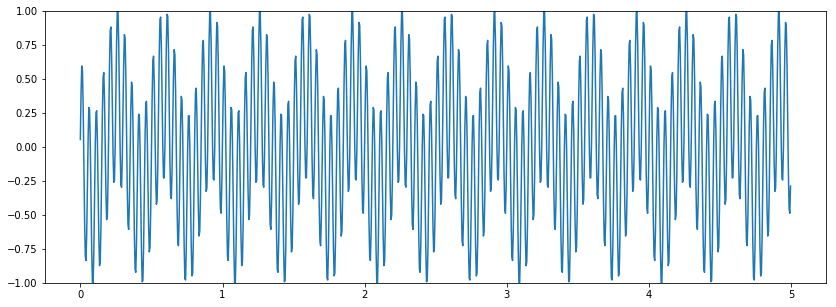

In [66]:
plt.figure(figsize=(14,5))
plt.ylim(-1,1)
plt.plot(t_list, data)
plt.show()

In [67]:
# Make input/ouput pairs: match datapoint (N) to each datapoint (N+1)
# data_pairs should be a list of data points like [(data_1, data_2), (data_2, data_3),...]
data_pairs = [(x, y) for x, y in zip(t_list, data)]

In [73]:
split_idx = int(len(data_pairs)*TRAIN_TEST_SPLIT )
train = data_pairs[:split_idx]
test = data_pairs[split_idx:]

train_x = np.array([x[0] for x in train])
train_y = np.array([x[1] for x in train])
train_x = np.reshape(train_x, (len(train_x), 1, 1))  # batch, #prev_context, #input nodes
train_y = np.reshape(train_y, (len(train_y), 1))     # batch, #prev_context, #output nodes

test_x = np.array([x[0] for x in test])
test_y = np.array([x[1] for x in test])
test_x = np.reshape(test_x, (len(test_x), 1, 1))  # batch, #prev_context, #input nodes
test_y = np.reshape(test_y, (len(test_y), 1))     # batch, #prev_context, #output nodes

In [74]:
test_x

array([[[3.5  ]],

       [[3.505]],

       [[3.51 ]],

       [[3.515]],

       [[3.52 ]],

       [[3.525]],

       [[3.53 ]],

       [[3.535]],

       [[3.54 ]],

       [[3.545]],

       [[3.55 ]],

       [[3.555]],

       [[3.56 ]],

       [[3.565]],

       [[3.57 ]],

       [[3.575]],

       [[3.58 ]],

       [[3.585]],

       [[3.59 ]],

       [[3.595]],

       [[3.6  ]],

       [[3.605]],

       [[3.61 ]],

       [[3.615]],

       [[3.62 ]],

       [[3.625]],

       [[3.63 ]],

       [[3.635]],

       [[3.64 ]],

       [[3.645]],

       [[3.65 ]],

       [[3.655]],

       [[3.66 ]],

       [[3.665]],

       [[3.67 ]],

       [[3.675]],

       [[3.68 ]],

       [[3.685]],

       [[3.69 ]],

       [[3.695]],

       [[3.7  ]],

       [[3.705]],

       [[3.71 ]],

       [[3.715]],

       [[3.72 ]],

       [[3.725]],

       [[3.73 ]],

       [[3.735]],

       [[3.74 ]],

       [[3.745]],

       [[3.75 ]],

       [[3.755]],

       [[3.7

In [69]:
print(len(test_x))

300


In [70]:
# Build LSTM model.

# Just an example. TODO: modify to improve performance:

model = Sequential()
model.add(LSTM(NUM_LSTM_NODES, batch_input_shape=(15, 1, 1), stateful=True))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

# compile model
model.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (15, 15)                  1020      
_________________________________________________________________
dense_21 (Dense)             (15, 10)                  160       
_________________________________________________________________
dense_22 (Dense)             (15, 1)                   11        
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


network structure of [1, 50, 100, 1] where we have 1 input layer (consisting of a sequence of size 50) which feeds into an LSTM layer with 50 neurons, that in turn feeds into another LSTM layer with 100 neurons which then feeds into a fully connected normal layer of 1 neuron with a linear activation function which will be used to give the prediction of the next time step.

In [71]:
layers =  [1, 400, 800, 1]
model = Sequential()

model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(layers[2], return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=layers[3]))
model.add(Activation("linear"))

model.summary()
model.compile(loss="mse", optimizer="rmsprop")
#model.compile(loss="mse", optimizer="adam")

C:\tools\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\tools\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=400)`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, None, 400)         643200    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 800)               3843200   
_________________________________________________________________
dropout_10 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 801       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 4,487,201
Trainable params: 4,487,201
Non-trainable params: 0
_________________________________________________________________


C:\tools\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # Remove the CWD from sys.path while we load stuff.


In [72]:
# fit model
for i in range(NUM_EPOCHS):
    print("Epoch %d" % i)
    model.fit(train_x, train_y, batch_size=1, epochs=1, shuffle=False, verbose=1)
    model.reset_states()

Epoch 0
Epoch 1/1
700/700 [==============================] - 6s 9ms/step - loss: 0.2595
Epoch 1
Epoch 1/1
700/700 [==============================] - 4s 5ms/step - loss: 0.2577
Epoch 2
Epoch 1/1
272/700 [==========>...................] - ETA: 2s - loss: 0.2670

KeyboardInterrupt: 

In [ ]:
model.fit(train_x, train_y, batch_size=1, epochs=10, shuffle=False, verbose=2)

In [ ]:
# Evaluate accuracy
scores = model.evaluate(test_x, test_y, batch_size=1, verbose=0)
model.reset_states()
print("Model Accuracy: %.2f%%" % (scores*100))

## Make predictions with the model

In [ ]:
result = []
for i in range(len(test_x)):
    prediction = model.predict(test_x[i].reshape(1,1,1), verbose=0)
    result.append([prediction, test_y[i]])
model.reset_states()  # Do this after giving an input sequence, to clear out hidden states.

In [ ]:
predictions = [[x[0][0][0], x[1][0]] for x in result]

In [ ]:
plt.plot(predictions[50:150])
plt.legend(('pred', 'actual'))
plt.show()

In [ ]:
errors = [abs(x[1] - x[0]) for x in predictions]

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN



def define_model(length_of_sequences, batch_size = None, stateful = False):
    in_out_neurons = 1
    hidden_neurons = 1
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  

    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)

    dens = Dense(in_out_neurons,name="dense")(rnn)
    model = Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    
    return(model,(inp,rnn,dens))
## use the default values for batch_size, stateful
model, (inp,rnn,dens) = define_model(length_of_sequences = train_x.shape[1])
model.summary()

In [ ]:
model.fit(train_x, train_y, batch_size=600, epochs=1000, 
                 verbose=False,validation_split=0.05)

In [ ]:
train_x

## Question 1: Discuss the results. How accurate was the model? What did you do to improve its accuracy? What problems did you run into?

In [ ]:
TODO

## Question 2: What problems did you run into, if any?

In [ ]:
TODO